In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import RandomUniform
from sklearn.model_selection import train_test_split
from pulp import LpProblem, LpMinimize, LpVariable
import pulp



In [2]:

def nearest_market_strike(strike, calls, puts, option_type=None):
    """
    Finds the nearest available market strike for calls/puts dataframes.
    """
    if option_type == 'call':
        relevant_options = calls.assign(option_type='call', sign=+1)
    elif option_type == 'put':
        relevant_options = puts.assign(option_type='put', sign=-1)
    else:  # combine both
        relevant_options = pd.concat([
            calls.assign(option_type='call', sign=+1),
            puts.assign(option_type='put', sign=-1)
        ], ignore_index=True)

    count = len(relevant_options)
    relevant_options['strike_diff'] = abs(relevant_options['strike'] - strike)
    nearest_option = relevant_options.loc[relevant_options['strike_diff'].idxmin()]

    return {
        'strike': nearest_option['strike'],
        'sign': nearest_option['sign'],
        'type': nearest_option['option_type'],
        'info': {
            'last_price': nearest_option['lastPrice'],
            'bid': nearest_option['bid'],
            'ask': nearest_option['ask'],
            'implied_volatility': nearest_option['impliedVolatility'],
            'open_interest': nearest_option['openInterest'],
        },
        'count': count
    }

########################################
# Provided payoff-building function
########################################

def real_call_payoff(strike):
    """
    Return a callable that, given S (shape=(batch_size,1)), 
    yields max(S - strike, 0).
    """
    def payoff_fn(S):
        return tf.nn.relu(S[:,0] - strike)
    return payoff_fn

def real_put_payoff(strike):
    """
    Return a callable that, given S (shape=(batch_size,1)), 
    yields max(strike - S, 0).
    """
    def payoff_fn(S):
        return tf.nn.relu(strike - S[:,0])
    return payoff_fn

def get_real_instrument_payoff(
    desired_strike, 
    option_type,
    calls_df, 
    puts_df
):
    """
    Finds the nearest real option for 'desired_strike' of type = option_type,
    then returns (payoff_fn, actual_strike, real_type).
    """
    nearest = nearest_market_strike(desired_strike, calls_df, puts_df, option_type=option_type)
    actual_strike = float(nearest['strike'])
    real_type     = nearest['type']  # 'call' or 'put'

    print('nearest option', nearest)
    
    # Create payoff
    if real_type == 'call':
        payoff_fn = real_call_payoff(actual_strike)
    else:
        payoff_fn = real_put_payoff(actual_strike)
    
    return payoff_fn, actual_strike, real_type


def create_unconstrained_net(input_dim=1, hidden_units=4, lr=0.01):
    """
    A simple neural net with ReLU hidden layer, 
    to replicate a payoff for demonstration.
    """
    uniform_initializer = RandomUniform(seed=10)
    model = Sequential()
    model.add(Input(shape=(input_dim,)))
    model.add(Dense(hidden_units, activation='relu', kernel_initializer=uniform_initializer))  # hidden
    model.add(Dense(1, activation='linear', kernel_initializer=uniform_initializer))           # final
    model.compile(optimizer=Adam(lr), loss='mse')
    return model

# def create_unconstrained_net(input_dim=1, hidden_units=4, lr=0.01):
#     """
#     A simple neural net with ReLU hidden layer, 
#     to replicate a payoff for demonstration.
#     """
#     # uniform_initializer = RandomUniform(seed=10)
#     model = Sequential()
#     model.add(Input(shape=(input_dim,)))
#     model.add(Dense(hidden_units, activation='relu'))  # hidden
#     model.add(Dense(1, activation='linear'))           # final
#     model.compile(optimizer=Adam(lr), loss='mse')
#     return model



def target_call_payoff(S, K=105.0):
    return np.maximum(S - K, 0.0)



In [3]:
def map_nn_weights_to_portfolio(model, calls_df, puts_df):
    """
    1) Extract hidden-layer weights (w1,b1).
    2) Extract final-layer weights (w2, b2).
    3) For each hidden neuron i, interpret (w1_i, b1_i, w2_i) -> forward/call/put/skip.
       The "units" = w2_i * (some function of w1_i, b1_i).
    4) Also store the final bias b2 as a "constant payoff"
    """

    dense_hidden = model.layers[0]  # e.g. Dense(relu)
    dense_final  = model.layers[1]  # e.g. Dense(1)

    # Hidden layer
    w1 = dense_hidden.get_weights()[0]  # shape (1, hidden_units)
    b1 = dense_hidden.get_weights()[1]  # shape (hidden_units,)
    w1 = w1.flatten()

    # Final layer
    w2, b2 = dense_final.get_weights()   # w2 shape (hidden_units,1), b2 shape (1,)
    w2 = w2.flatten()  # shape (hidden_units,)
    b2 = b2[0]

    portfolio = []

    # interpret b2 as a "constant payoff" or "cash"
    if abs(b2) > 1e-8:
        portfolio.append({
            'instrument': 'cash',
            'strike': None,
            'units': b2,
            'comment': 'final-layer bias'
        })

    hidden_units = len(b1)
    for i in range(hidden_units):
        wi = w1[i]    # from hidden layer
        bi = b1[i]
        w2i = w2[i]   # final layer scaling

        # The "raw" shape is ReLU(wi*S + bi).
        # We interpret sign of (wi, bi) as forward/call/put
        # But the actual "units" in final payoff is w2i * that shape
        # So let's define "effective_units" = w2i * wi or just w2i if we interpret carefully.

        if wi >= 0 and bi >= 0:
            # forward-like => payoff ~ S
            effective_units = w2i * wi
            if abs(effective_units) < 1e-8:
                continue
            portfolio.append({
                'instrument': 'forward',
                'strike': None,
                'units': effective_units,
                'comment': f"hidden {i}, w2={w2i:.3f}, w1={wi:.3f}, b1={bi:.3f}"
            })

        elif wi > 0 and bi < 0:
            # call-like => strike = -bi/wi
            implied_strike = -bi / wi
            # find nearest real call
            nearest_call = nearest_market_strike(implied_strike, calls_df, puts_df, 'call')
            chosen_strike = float(nearest_call['strike'])

            # final "units" is w2i * wi
            effective_units = w2i * wi
            if abs(effective_units) < 1e-8:
                continue
            portfolio.append({
                'instrument': 'call',
                'strike': chosen_strike,
                'units': effective_units,
                'comment': f"hidden {i}, w2={w2i:.3f}, w1={wi:.3f}, b1={bi:.3f}"
            })

        elif wi < 0 and bi > 0:
            # put-like => strike = -bi/wi
            implied_strike = -bi / wi
            nearest_put = nearest_market_strike(implied_strike, calls_df, puts_df, 'put')
            chosen_strike = float(nearest_put['strike'])

            # We might want units= - (w2i * wi) if we interpret negative as short
            # But for simplicity, store directly w2i*wi.
            effective_units = w2i * wi
            if abs(effective_units) < 1e-8:
                continue
            portfolio.append({
                'instrument': 'put',
                'strike': chosen_strike,
                'units': effective_units,
                'comment': f"hidden {i}, w2={w2i:.3f}, w1={wi:.3f}, b1={bi:.3f}"
            })

        else:
            # skip "dead" or negligible
            continue

    return portfolio


def forward_payoff(strike_ignored=None):
    """ 
    Basic forward payoff => payoff_fn(S) = S[:,0]. 
    """
    def payoff_fn(S):
        return S[:,0]
    return payoff_fn

def portfolio_to_payoff_array(portfolio, S_array):
    S_tensor = tf.convert_to_tensor(S_array.reshape(-1,1), dtype=tf.float32)
    total_payoff = tf.zeros(shape=(len(S_array),), dtype=tf.float32)

    for item in portfolio:
        instr  = item['instrument']
        strike = item.get('strike', None)
        units  = item['units']

        if instr == 'constant':
            # Just add units for every S
            payoff_vec = tf.ones_like(S_tensor[:,0]) * units

        elif instr == 'forward':
            payoff_fn = forward_payoff(None)
            payoff_vec = payoff_fn(S_tensor) * units

        elif instr == 'call':
            payoff_fn = real_call_payoff(strike)
            payoff_vec = payoff_fn(S_tensor) * units

        elif instr == 'put':
            payoff_fn = real_put_payoff(strike)
            payoff_vec = payoff_fn(S_tensor) * units

        else:
            payoff_vec = tf.zeros_like(S_tensor[:,0])

        total_payoff += payoff_vec

    return total_payoff.numpy()




In [4]:
def portfolio_to_instruments_dict(portfolio):
    """
    Translate the list of {instrument, strike, units, ...} from map_nn_weights_to_portfolio
    into a list of payoff functions for build_real_instruments_model.

    We do NOT multiply by 'units' here, because the final Dense(1) layer 
    in the real-instruments model will learn (or refine) the weights.
    """
    instruments_dict = []

    for item in portfolio:
        instr_type = item['instrument']
        strike     = item['strike']

        if instr_type == 'forward':
            # A forward payoff: f(S) = S
            payoff_fn = forward_payoff(None)

        elif instr_type == 'call':
            # Real call payoff: max(S - strike, 0)
            payoff_fn = real_call_payoff(strike)

        elif instr_type == 'put':
            # Real put payoff: max(strike - S, 0)
            payoff_fn = real_put_payoff(strike)

        else:
            # skip anything else (e.g. 'dead' or unexpected)
            continue

        instruments_dict.append(payoff_fn)

    return instruments_dict


In [5]:
class RealInstrumentsLayer(tf.keras.layers.Layer):
    """
    A custom layer that takes in S (shape=(batch_size, 1)) 
    and outputs a vector [f1(S), f2(S), ..., fL(S)] for each real instrument.
    """
    def __init__(self, instruments_dict, **kwargs):
        super().__init__(**kwargs)
        self.instruments_dict = instruments_dict

    def call(self, inputs):
        # inputs: shape (batch_size, 1)
        payoff_list = []
        for payoff_fn in self.instruments_dict:
            payoff = payoff_fn(inputs)  
            payoff = tf.reshape(payoff, [-1, 1])  # shape (batch_size,1)
            payoff_list.append(payoff)

        return tf.concat(payoff_list, axis=1)  # shape => (batch_size, L)


In [6]:
def build_real_instruments_model(instruments_dict, nonnegative=False):
    constraint = tf.keras.constraints.NonNeg() if nonnegative else None
    model = tf.keras.Sequential([
        RealInstrumentsLayer(instruments_dict=instruments_dict),
        tf.keras.layers.Dense(1, use_bias=True, activation=None,
                              kernel_constraint=constraint)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model


In [7]:
def generate_underlying_prices(
    n_samples=2000, 
    S0=100.0, 
    r=0.05,        # risk-free rate for risk-neutral measure
    sigma=0.2, 
    T=1.0
):
    """
    Generate final prices S_T by simulating under the risk-neutral measure:
      S_T = S0 * exp( (r - 0.5 * sigma^2)*T + sigma * sqrt(T) * Z )

    Args:
        n_samples (int): number of simulated terminal prices
        S0 (float):      initial underlying price at t=0
        r   (float):     risk-free interest rate
        sigma (float):   volatility
        T   (float):     time to maturity (in years, e.g. 1.0 = 1 year)

    Returns:
        np.array of shape (n_samples,) containing terminal prices under Q.
    """
    Z = np.random.normal(loc=0.0, scale=1.0, size=n_samples)
    drift = (r - 0.5 * sigma**2) * T
    diffusion = sigma * np.sqrt(T) * Z
    ST = S0 * np.exp(drift + diffusion)
    return ST


In [8]:
# Generate the *same data* for both unconstrained and real-instruments approach
K_TARGET = 105
S0=100


S_data = generate_underlying_prices(3000, S0=S0, r=0.05, sigma=0.2)
y_data = target_call_payoff(S_data, K_TARGET)

###############################################################################
# 2) Build and train "unconstrained" net
S_data_normalized = S_data / S0
K_TARGET_normalized = K_TARGET / S0

X_all = S_data.reshape(-1,1).astype('float32')
y_all = y_data.reshape(-1,1).astype('float32')



# Train/test split
X_train_uc, X_val_uc, y_train_uc, y_val_uc = train_test_split(
    X_all, y_all, test_size=0.2, random_state=42
)



In [9]:
S_data

array([140.60578244, 109.28131126,  96.94799416, ..., 119.54728503,
       108.73009265, 171.95935504], shape=(3000,))

Epoch 379: early stopping
Restoring model weights from the end of the best epoch: 369.
Finished training the unconstrained RLNN on the same data.

=== MAPPED PORTFOLIO (from unconstrained net) ===
{'instrument': 'cash', 'strike': None, 'units': np.float32(-3.395e-05), 'comment': 'final-layer bias'}
{'instrument': 'call', 'strike': 105.0, 'units': np.float32(0.37142846), 'comment': 'hidden 1, w2=3.139, w1=0.118, b1=-12.425'}
{'instrument': 'call', 'strike': 105.0, 'units': np.float32(0.62856984), 'comment': 'hidden 3, w2=4.617, w1=0.136, b1=-14.296'}
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step

Epoch 234: early stopping
Restoring model weights from the end of the best epoch: 224.
Finished re-fitting the real-instrument model on the same data.

Total candidate instruments: 7
LP Minimax solution, E = 0.0
alpha_sol shape: (7,)
Alpha solution snippet: [0. 1. 0. 0. 0. 0. 0.] ...
Selected 1 instruments after pruning with threshold=0.0001
Epoch 468: early stopping
Restoring model weights from the en

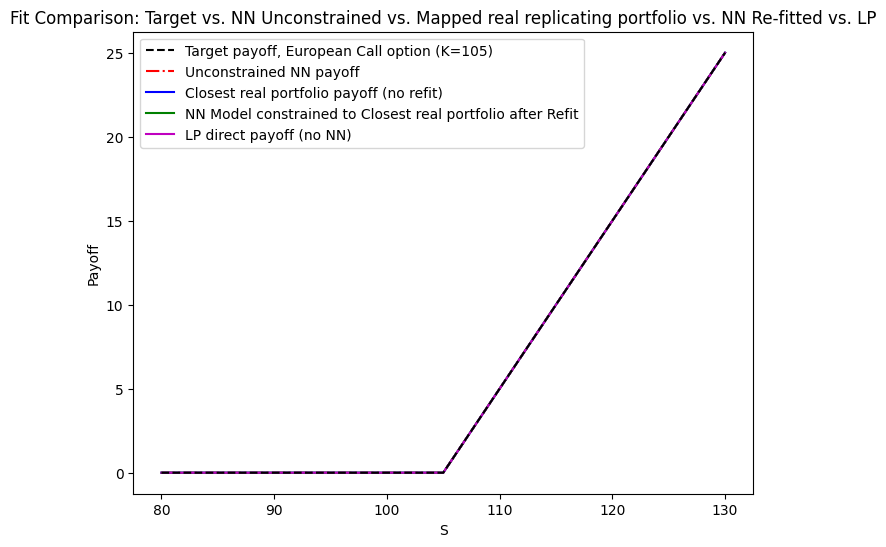

MSE( NN vs Target )      = 0.0000
MSE( Mapped vs Target )  = 0.0000

MSE( Refit vs Target ) = 0.0000

MSE( LP-based subset re-fit vs Target ) = 0.0000

(Refitted model) Final layer weights shape = (2, 1)
(Refitted model) Final layer bias shape    = (1,)
(Refitted model) Weights: [ 1.0392692  -0.03926921]
(Refitted model) Bias: 1.6640139e-07


In [10]:
unconstrained_model = create_unconstrained_net(hidden_units=4, lr=0.01)

early_stopping_uc = EarlyStopping(
    monitor='val_loss', mode='min',
    patience=10, restore_best_weights=True, verbose=1
)

unconstrained_model.fit(
    X_train_uc, y_train_uc,
    epochs=3000,
    batch_size=int(0.1 * X_train_uc.shape[0]),
    validation_data=(X_val_uc, y_val_uc),
    callbacks=[early_stopping_uc],
    verbose=0
)

print("Finished training the unconstrained RLNN on the same data.\n")


###############################################################################
# 3) Map NN => real portfolio
###############################################################################

# Pull real market data (AAPL example):
ticker_symbol   = 'AAPL'
expiration_date = '2025-01-10'
ticker = yf.Ticker(ticker_symbol)
chain = ticker.option_chain(expiration_date)
calls_df = chain.calls
puts_df  = chain.puts

# 3.1) Map hidden neurons => portfolio
portfolio = map_nn_weights_to_portfolio(unconstrained_model, calls_df, puts_df)
print("=== MAPPED PORTFOLIO (from unconstrained net) ===")
for p in portfolio:
    print(p)
len('lenght of portfolio')
###############################################################################
# 4) Evaluate "naive" mapped portfolio vs. unconstrained net vs. target
###############################################################################

S_test = np.linspace(80, 130, 51)
X_test_plot = S_test.reshape(-1,1).astype('float32')

mapped_payoffs_naive = portfolio_to_payoff_array(portfolio, S_test)

nn_payoffs = unconstrained_model.predict(X_test_plot).flatten()
target_payoff_vec = np.maximum(S_test - K_TARGET, 0.0)


###############################################################################
# 5) Refit a new "Real Instruments" model on the *same data*
###############################################################################

def portfolio_to_instruments_dict(portfolio):
    """
    Convert the mapped portfolio to a list of bare payoff_fns
    (ignoring 'units'), so the new model can learn the combination.
    """
    instruments_list = []
    for item in portfolio:
        instr = item['instrument']
        strike = item['strike']
        if instr == 'forward':
            payoff_fn = forward_payoff(None)
        elif instr == 'call':
            payoff_fn = real_call_payoff(strike)
        elif instr == 'put':
            payoff_fn = real_put_payoff(strike)
        else:
            continue
        instruments_list.append(payoff_fn)
    return instruments_list

instruments_dict = portfolio_to_instruments_dict(portfolio)

# Build the real-instrument model
model_real = build_real_instruments_model(instruments_dict, nonnegative=False)

# We'll re-split the *same data* (X_all, y_all) for training/validation
X_train_r, X_val_r, y_train_r, y_val_r = train_test_split(
    X_all, y_all, test_size=0.2, random_state=42
)

early_stopping_r = EarlyStopping(
    monitor='val_loss', mode='min',
    patience=10, restore_best_weights=True, verbose=1
)

model_real.fit(
    X_train_r, y_train_r,
    epochs=500,
    batch_size=int(0.1 * X_train_r.shape[0]),
    validation_data=(X_val_r, y_val_r),
    callbacks=[early_stopping_r],
    verbose=0
)

print("Finished re-fitting the real-instrument model on the same data.\n")



###############################################################################
# 5) LP Step: Build big dictionary of real instruments, replicate payoff
###############################################################################
def build_instrument_payoff_matrix(instrument_list, S_values):
    """
    instrument_list: e.g. [('forward', None), ('call', 100.0), ('put', 95.0), ...]
    S_values: array shape (N,). We'll build matrix shape (N, L).
    """
    N = len(S_values)
    L = len(instrument_list)
    payoff_matrix = np.zeros((N,L), dtype=float)

    for j, (typ, strike) in enumerate(instrument_list):
        if typ == 'forward':
            payoff_fn = forward_payoff(None)
        elif typ == 'call':
            payoff_fn = real_call_payoff(strike)
        elif typ == 'put':
            payoff_fn = real_put_payoff(strike)
        else:
            # skip unknown
            def payoff_fn(S):
                return tf.zeros_like(S[:,0])

        S_tensor = tf.convert_to_tensor(S_values.reshape(-1,1), dtype=tf.float32)
        p = payoff_fn(S_tensor).numpy().flatten()
        payoff_matrix[:,j] = p

    return payoff_matrix

def solve_lp_minimax(payoff_matrix, target_payoff, alpha_nonneg=True):
    """
    Minimally-viable L-infinity approach:
      min E s.t. for all i:
         -E <= sum_j alpha_j * payoff_matrix[i,j] - target_payoff[i] <= E,
    If alpha_nonneg=True => alpha_j >= 0
    """

    N, L = payoff_matrix.shape
    prob = LpProblem("replicate_payoff", LpMinimize)

    alpha_vars = []
    for j in range(L):
        if alpha_nonneg:
            alpha_vars.append(LpVariable(f"alpha_{j}", lowBound=0))
        else:
            alpha_vars.append(LpVariable(f"alpha_{j}", lowBound=None))

    E = LpVariable("E", lowBound=0)

    # Objective
    prob += E

    for i in range(N):
        row_sum = None
        for j in range(L):
            row_sum = alpha_vars[j]*payoff_matrix[i,j] if row_sum is None else row_sum + alpha_vars[j]*payoff_matrix[i,j]
        # row_sum - target_payoff[i] <= E
        prob += row_sum - target_payoff[i] <= E
        # -(row_sum - target_payoff[i]) <= E => target_payoff[i] - row_sum <= E
        prob += target_payoff[i] - row_sum <= E

    prob.solve(pulp.PULP_CBC_CMD(msg=0))

    alpha_sol = np.array([v.varValue for v in alpha_vars])
    E_sol = E.varValue
    return alpha_sol, E_sol

# 5.1) Build a big dictionary from calls_df, puts_df (plus forward)
all_instruments = []
# Forward
all_instruments.append(('forward', None))

# Let's pick calls with strike around target strike, from e.g. 90 to 115
for idx, row in calls_df.iterrows():
    strike = float(row['strike'])
    if 90 <= strike <= 115:
        all_instruments.append(('call', strike))

# Similarly pick puts from e.g. 90 to 115
for idx, row in puts_df.iterrows():
    strike = float(row['strike'])
    if 90 <= strike <= 115:
        all_instruments.append(('put', strike))

print(f"Total candidate instruments: {len(all_instruments)}")

# 5.2) Build payoff matrix for S_test, solve LP to replicate target payoff
payoff_mat_lp = build_instrument_payoff_matrix(all_instruments, S_test)
alpha_sol, E_sol = solve_lp_minimax(payoff_mat_lp, target_payoff_vec, alpha_nonneg=True)

lp_payoffs_direct = payoff_mat_lp @ alpha_sol


print("LP Minimax solution, E =", E_sol)
print("alpha_sol shape:", alpha_sol.shape)
print("Alpha solution snippet:", alpha_sol[:10], "...")

# 5.3) Prune small weights
threshold = 1e-4
selected_instruments = []
for (typ, strike), alpha_val in zip(all_instruments, alpha_sol):
    if alpha_val > threshold:
        selected_instruments.append((typ, strike))

print(f"Selected {len(selected_instruments)} instruments after pruning with threshold={threshold}")



###############################################################################
# 6) Build RealInstrumentsLayer with selected instruments, re-fit
###############################################################################
def build_instruments_dict_from_tuples(instrument_tuples):
    """
    Convert a list of (type, strike) into a list of payoff_fns
    """
    instruments_list = []
    for (typ, strike) in instrument_tuples:
        if typ == 'forward':
            payoff_fn = forward_payoff(None)
        elif typ == 'call':
            payoff_fn = real_call_payoff(strike)
        elif typ == 'put':
            payoff_fn = real_put_payoff(strike)
        else:
            # skip unknown
            payoff_fn = None
        if payoff_fn is not None:
            instruments_list.append(payoff_fn)
    return instruments_list

# Build RealInstrumentsLayer-based model
model_lp = build_real_instruments_model(
    build_instruments_dict_from_tuples(selected_instruments),
    nonnegative=False
)

# Same data split
X_train_lp, X_val_lp, y_train_lp, y_val_lp = train_test_split(
    X_all, y_all, test_size=0.2, random_state=42
)

early_stopping_lp = EarlyStopping(monitor='val_loss', mode='min',
                                  patience=10, restore_best_weights=True, verbose=1)

model_lp.fit(
    X_train_lp, y_train_lp,
    epochs=500,
    batch_size=int(0.1 * X_train_lp.shape[0]),
    validation_data=(X_val_lp, y_val_lp),
    callbacks=[early_stopping_lp],
    verbose=0
)

###############################################################################
# 7) Evaluate final payoff from LP-based model
###############################################################################
y_lp_refit = model_lp.predict(X_test_plot).flatten()

y_refit = model_real.predict(X_test_plot).flatten()
plt.figure(figsize=(8,6))
plt.plot(S_test, target_payoff_vec, 'k--', label='Target payoff, European Call option (K=105)',zorder = 99)
plt.plot(S_test, nn_payoffs, 'r-.', label='Unconstrained NN payoff')
plt.plot(S_test, mapped_payoffs_naive, 'b-', label='Closest real portfolio payoff (no refit)')
plt.plot(S_test, y_refit, 'g-', label='NN Model constrained to Closest real portfolio after Refit')
# plt.plot(S_test, y_lp_refit, 'c-', label='LP-based subset => RealInstrumentsLayer fit')
plt.plot(S_test, lp_payoffs_direct,  'm-', label='LP direct payoff (no NN)')
plt.xlabel("S")
plt.ylabel("Payoff")

plt.title("Fit Comparison: Target vs. NN Unconstrained vs. Mapped real replicating portfolio vs. NN Re-fitted vs. LP")
plt.legend()
plt.show()

mse_nn = np.mean((nn_payoffs - target_payoff_vec)**2)
mse_map = np.mean((mapped_payoffs_naive - target_payoff_vec)**2)
mse_refit = np.mean((y_refit - target_payoff_vec)**2)
mse_lp_refit = np.mean((y_lp_refit - target_payoff_vec)**2)
print(f"MSE( NN vs Target )      = {mse_nn:.4f}")
print(f"MSE( Mapped vs Target )  = {mse_map:.4f}\n")
print(f"MSE( Refit vs Target ) = {mse_refit:.4f}\n")
print(f"MSE( LP-based subset re-fit vs Target ) = {mse_lp_refit:.4f}\n")

# Inspect final layer weights
dense_final = model_real.layers[-1]
w_final, b_final = dense_final.get_weights()
print("(Refitted model) Final layer weights shape =", w_final.shape)
print("(Refitted model) Final layer bias shape    =", b_final.shape)
print("(Refitted model) Weights:", w_final.flatten())
print("(Refitted model) Bias:", b_final[0])


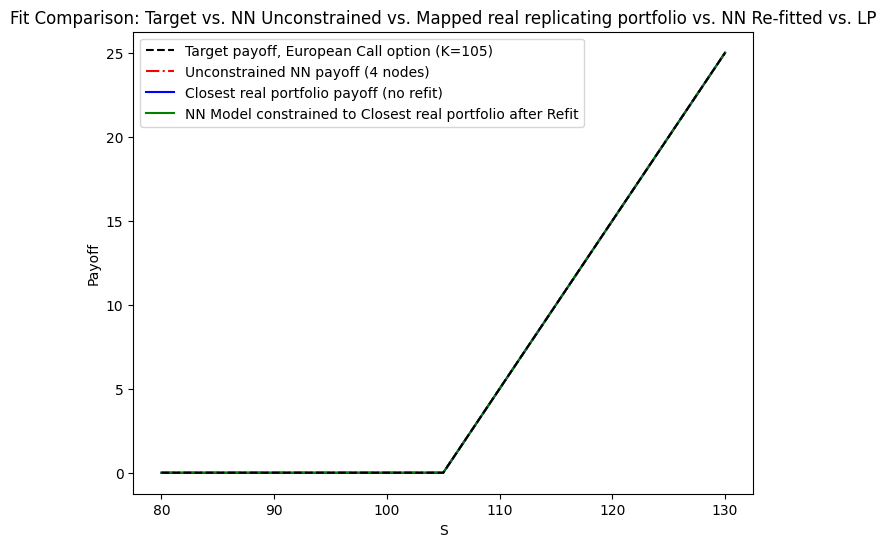

In [11]:
plt.figure(figsize=(8,6))
plt.plot(S_test, target_payoff_vec, 'k--', label='Target payoff, European Call option (K=105)', zorder=99)
plt.plot(S_test, nn_payoffs, 'r-.', label='Unconstrained NN payoff (4 nodes)')
plt.plot(S_test, mapped_payoffs_naive, 'b-', label='Closest real portfolio payoff (no refit)')
plt.plot(S_test, y_refit, 'g-', label='NN Model constrained to Closest real portfolio after Refit')
# plt.plot(S_test, y_lp_refit, 'c-', label='LP-based subset => RealInstrumentsLayer fit')
# plt.plot(S_test, lp_payoffs_direct,  'm-', label='LP direct payoff (no NN)')
plt.xlabel("S")
plt.ylabel("Payoff")
plt.xlabel("S")
plt.ylabel("Payoff")

plt.title("Fit Comparison: Target vs. NN Unconstrained vs. Mapped real replicating portfolio vs. NN Re-fitted vs. LP")
plt.legend()
plt.show()



In [12]:
import numpy as np
from scipy.stats import norm
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split



def stock_price_simulator(S0, mu, sigma, T, N, M):
    """_summary_

    Args:
        S0 (_type_): initial stock price
        mu (_type_): risk free rate
        sigma (_type_): volatility
        T (_type_): time to maturity
        N (_type_): number of time steps
        M (_type_): number of simulations

    Returns:
        S : Stock price Paths of M simulations
    """
    dt = T/N
    S = np.zeros((M, N+1))
    S[:, 0] = S0
    for i in range(1, N+1):
        S[:, i] = S[:, i-1] * np.exp((mu - 0.5*sigma**2)*dt + sigma*np.sqrt(dt)*np.random.normal(size=M))
    
    return S

def payoff_fun(S, K, option_type):
    """

    Args:
        S (_type_): Stock price
        K (_type_): Strike price
        option_type (_type_): type of option, call or put
    Returns:
        payoff : payoff of the option
    """
    if option_type == 'call':
        return np.maximum(S - K, 0)
    elif option_type == 'put':
        return np.maximum(K - S, 0)
    
def create_shallow_NN(input_dim, hidden_units):
    """
    Create a shallow neural network with 1 hidden layer

    Args:
        input_dim (int): number of nodes in input layer
        hidden_units (int): number of nodes in hidden layer

    Returns:
        model : Neural network model
    """
    model = Sequential()
    # Use Input layer for specifying input shape
    model.add(Input(shape=(input_dim,)))
    model.add(Dense(hidden_units, activation='relu', kernel_initializer='random_uniform', bias_initializer= 'random_uniform'))
    model.add(Dense(1, activation='linear', kernel_initializer='random_normal', bias_initializer= 'random_uniform'))
    
    return model

def black_scholes(S, K, r, sigma, T, option_type='call'):
    """ 
    Calculate the price of a European option using Black-Scholes formula

    Args:
        S (_type_): Initial Stock price
        K (_type_): Strike price
        r (_type_): risk free rate
        sigma (_type_): volatility
        T (_type_): time to maturity
        option_type (str, optional): type of option .

    Returns:
        price of the option
    """
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    
    if option_type == 'call':
        return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    elif option_type == 'put':
        return K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)
    
def expected_value(wi, bi, Stm_1, r, sigma, dt):
    """
    Calculate E[max(wi * Stm + bi, 0) | St] based on the cases provided.

    Parameters:
    - wi : float, weight parameter
    - bi : float, bias parameter
    - Stm : float, price at time t_m

    Returns:
    - float, expected value based on the case
    """
    if wi >= 0 and bi >= 0:
        # Case 1: Price of a forward contract
        ### Forward Price Impelmentation
        return wi * Stm_1 * np.exp(r * dt) + bi

    elif wi > 0 and bi < 0:
        # Case 2: Value of a European call option
        strike = -bi / wi
        # Using max(0, Stm - strike) to approximate the expectation
        ### Implement
        return wi * black_scholes(Stm_1, strike, r, sigma, dt, option_type='call')

    elif wi < 0 and bi > 0:
        # Case 3: Value of a European put option
        strike = -bi / wi
        return - wi * black_scholes(Stm_1, strike, r, sigma, dt, option_type='put')

    elif wi <= 0 and bi <= 0:
        # Case 4: Expected value is 0
        return 0.0
    
def cal_continuation_value(w1, b1, w2, b2, no_hidden_units, stock_prices, r, sigma, dt, M, normalizer):
    """ Calculate the continuation value of the Bermudan option

    Args:
        w1 (array): Weights of the first layer
        b1 (array): Biases of the first layer
        w2 (array): Weights of the second layer
        b2 (float): Biases of the second layer
        no_hidden_units (int): Number of hidden units
        stock_prices (float): Stock prices at time
        r (float): Risk free rate
        sigma (float): volatility
        dt (_type_): time step
        M (_type_): number of simulations(samples)
        normalizer (_type_): normalizer for the stock prices

    Returns:
        _type_: _description_
    """
    normalized_stock_values = stock_prices/normalizer
    continuation_value = np.zeros(M)
    for j in range(M):
        for i in range(no_hidden_units):
            continuation_value[j] += expected_value(w1[i], b1[i], normalized_stock_values[j], r, sigma, dt) * w2[i]
        continuation_value[j] += b2
    
    return continuation_value * np.exp(-r*dt)




def RLNN_Algo(S0, K, r, vol, sample_size, no_mon, T, style, no_hidden_units, l_rate2):
    """
    Args:
        S0 (): Initial stock price
        K (_type_): Stirke price
        r (_type_): risk free rate
        vol (_type_): volatility
        sample_size (_type_): number of samples to generate
        no_mon (_type_): Number of monitoring dates
        style (_type_): option type
        no_hidden_units (_type_): number of hidden units in the neural network
    """
    
    weights = []
    errors = []
    N = no_mon
    
    stock_paths = stock_price_simulator(S0, r, vol, T, no_mon, sample_size)
    ## Initialize the option price matrix
    option_price = np.zeros(stock_paths.shape)
    ## Calculate the option price at the maturity date
    option_price[:, N] = payoff_fun(stock_paths[:, N], K, style)
    payoff_T = payoff_fun(stock_paths[:, N], K, style)
     
    X = stock_paths[:, N].reshape(-1, 1)
    ## Normalize the stock prices
    normalizer = S0
    normalized_stock_paths = stock_paths[:, N]/normalizer
    ## X_train and y_train for the neural network
    X = normalized_stock_paths.reshape(-1, 1)
    y = payoff_T.reshape(-1, 1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
    # Compile the model
    es = EarlyStopping(monitor='val_loss', mode='min', patience=5)
    model2  = create_shallow_NN(1, no_hidden_units)
    model2.compile(loss='mean_squared_error', optimizer=Adam(l_rate2))
    ## Train the model  
    model2.fit(X_train, y_train, epochs=3000, batch_size=int(0.1 * X_train.shape[0]), 
              validation_data=(X_test, y_test), callbacks=[es], verbose = 0)
    
    # Test the model
    y_hat_val = model2.predict(X_test)
    
    errors.append(np.mean((y_test - y_hat_val)**2)) ## Store the errors for Last monitoring date
    
    ## Get the weights of the model
    w1 = model2.layers[0].get_weights()[0].reshape(-1)
    b1 = model2.layers[0].get_weights()[1].reshape(-1)
    w2 = model2.layers[1].get_weights()[0].reshape(-1)
    b2 = model2.layers[1].get_weights()[1].reshape(-1)
    
    ## Store the weights 
    weights.append(model2.get_weights())
    
    ## Calculate the continuation value 
    continuation_value = cal_continuation_value(w1, b1, w2, b2, no_hidden_units, stock_paths[:, N-1], r, vol, T/N, sample_size, normalizer)
    ##print(continuation_value[continuation_value < 0])
    fun_h = payoff_fun(stock_paths[:, N-1], K, style)               # Payoff at the previous monitoring date
    if N == 1:
        option_price[:, N-1] = continuation_value
    else:
        option_price[:, N-1] = np.maximum(fun_h, continuation_value)    # Option price at the previous monitoring date
    
    
    ## Calculate the option price at the previous monitoring dates
    
    model2.optimizer.learning_rate.assign(0.01)
    
    for i in range(N-1, 0, -1):
        normalizer = S0
        normalized_stock_paths = stock_paths[:, i]/normalizer
        X = normalized_stock_paths.reshape(-1, 1)
        y = option_price[:, i].reshape(-1, 1)
        es2 = EarlyStopping(monitor='val_loss', mode='min', patience=20,restore_best_weights=True, min_delta=0.00001, verbose=1)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
        model2.fit(X_train, y_train, epochs=3000, batch_size=int(0.1 * X_train.shape[0]), 
                  validation_data=(X_test, y_test), callbacks=[es2], verbose =0)
        
        y_hat = model2.predict(X_test)
        
        errors.append(np.mean((y_test - y_hat)**2))    ## Store the errors for the previous monitoring dates
        
        # compute the continuation value
        w1 = model2.layers[0].get_weights()[0].reshape(-1)
        b1 = model2.layers[0].get_weights()[1].reshape(-1)
        w2 = model2.layers[1].get_weights()[0].reshape(-1)
        b2 = model2.layers[1].get_weights()[1].reshape(-1)
        weights.append(model2.get_weights())
        continuation_value = cal_continuation_value(w1, b1, w2, b2, no_hidden_units, stock_paths[:, i-1], r, vol, T/N, sample_size, normalizer)
        fun_h = payoff_fun(stock_paths[:, i-1], K, style)            # Payoff at the previous monitoring date
        if i == 1:
            option_price[:, i-1] = continuation_value
        
        else:
            option_price[:, i-1] = np.maximum(fun_h, continuation_value)    
        
    return option_price[0,0] , weights, errors


In [13]:
def RLNN_Algo_with_RealRefit(
    S0, K, r, vol, sample_size, no_mon, T, style,
    no_hidden_units, l_rate2,
    calls_df, puts_df,
    mismatch_tol=1e-3, 
    do_plot=True
):
    """
    RLNN algorithm for Bermudan option, but inside each backward step:
      1) Train unconstrained net,
      2) Interpret as real instruments,
      3) Build & re-fit a RealInstruments net,
      4) Compare mismatch with the unconstrained net’s predicted payoff,
      5) If mismatch is small, use real net for continuation value.

    Returns:
        final_price      : float
        all_weights_uncon: list of unconstrained NN weights per date
        all_weights_real : list of real-instrument net weights per date
        errors_uncon     : MSE errors of unconstrained net
        errors_real      : MSE errors of real-instrument net
        real_portfolios  : list of real-instrument portfolios used at each date
    """
    all_weights_uncon = []
    all_weights_real  = []
    errors_uncon      = []
    errors_real       = []
    real_portfolios   = []

    N = no_mon

    # ========== (A) Generate stock paths ==========
    stock_paths = stock_price_simulator(S0, r, vol, T, no_mon, sample_size)
    option_price = np.zeros_like(stock_paths)

    # payoff at final time
    option_price[:, N] = payoff_fun(stock_paths[:, N], K, style)

    # ========== (B) Fit unconstrained net at final time (t=N) ==========
    payoff_T = option_price[:, N]

    # We'll keep the unconstrained net training with *scaled* X if you like:
    X_scaled = (stock_paths[:, N] / S0).reshape(-1, 1)  
    y = payoff_T.reshape(-1, 1)

    # Use test_size=0.2 to match your working snippet
    X_train_sc, X_test_sc, y_train_sc, y_test_sc = train_test_split(
        X_scaled, y, test_size=0.2, random_state=42
    )

    # Make the EarlyStopping settings consistent
    es_uncon = EarlyStopping(
        monitor='val_loss', mode='min',
        patience=10, restore_best_weights=True, verbose=0
    )

    # Unconstrained net
    model_uncon = create_shallow_NN(1, no_hidden_units)
    model_uncon.compile(loss='mse', optimizer=Adam(l_rate2))
    model_uncon.fit(
        X_train_sc, y_train_sc,
        epochs=2000,
        batch_size=int(0.1 * X_train_sc.shape[0]),
        validation_data=(X_test_sc, y_test_sc),
        callbacks=[es_uncon],
        verbose=0
    )

    # MSE for unconstrained net
    y_hat_test_sc = model_uncon.predict(X_test_sc)
    mse_un = np.mean((y_test_sc - y_hat_test_sc)**2)
    errors_uncon.append(mse_un)

    # Store weights
    all_weights_uncon.append(model_uncon.get_weights())

    # ========== (B.1) Map unconstrained net => real instruments ==========
    portfolio_T = map_nn_weights_to_portfolio(model_uncon, calls_df, puts_df)
    real_portfolios.append(portfolio_T)

    # ========== (B.2) Build real instruments net ==========
    instruments_dict_T = portfolio_to_instruments_dict(portfolio_T)
    model_realT = build_real_instruments_model(instruments_dict_T, nonnegative=False)

    # IMPORTANT: Real net sees *unscaled* inputs
    X_unscaled = stock_paths[:, N].reshape(-1,1)

    # Train/val split (test_size=0.2) with unscaled X
    X_train_un, X_val_un, y_train_un, y_val_un = train_test_split(
        X_unscaled, y, test_size=0.2, random_state=42
    )

    # Same EarlyStopping approach
    es_real = EarlyStopping(
        monitor='val_loss', mode='min',
        patience=10, restore_best_weights=True, verbose=0
    )

    # Fit the real net
    model_realT.fit(
        X_train_un, y_train_un,
        epochs=2000,
        batch_size=int(0.1 * X_train_un.shape[0]),
        validation_data=(X_val_un, y_val_un),
        callbacks=[es_real],
        verbose=0
    )

    # measure mismatch
    y_hat_real_test = model_realT.predict(X_val_un)
    mse_real = np.mean((y_val_un - y_hat_real_test)**2)
    errors_real.append(mse_real)

    mismatch = abs(mse_real - mse_un)
    # if mismatch > mismatch_tol:

    all_weights_real.append(model_realT.get_weights())

    # For maturity, use the real net's predictions for consistency
    # We'll still pass the same scaled X for the unconstrained net,
    # but for the real net, it must be unscaled:
    cont_values = model_realT.predict(X_unscaled)[:, 0]
    option_price[:, N] = cont_values

    # ========== (C) Backward steps from i=N-1 down to i=1 ==========
    for i in range(N-1, 0, -1):
        # -- 1) Prepare data for unconstrained net (still scaled) --
        X_input_scaled = (stock_paths[:, i] / S0).reshape(-1, 1)
        y_target = option_price[:, i].reshape(-1, 1)

        # train/val split for unconstrained net
        X_tr_sc, X_val_sc, y_tr_sc, y_val_sc = train_test_split(
            X_input_scaled, y_target, test_size=0.2, random_state=42
        )

        # Unconstrained net
        es2_uncon = EarlyStopping(
            monitor='val_loss', mode='min',
            patience=10, restore_best_weights=True, verbose=0
        )
        model_uncon2 = create_shallow_NN(1, no_hidden_units)
        model_uncon2.compile(loss='mse', optimizer=Adam(0.01))
        model_uncon2.fit(
            X_tr_sc, y_tr_sc,
            epochs=2000,
            batch_size=int(0.1 * X_tr_sc.shape[0]),
            validation_data=(X_val_sc, y_val_sc),
            callbacks=[es2_uncon],
            verbose=0
        )

        # MSE for unconstrained net
        y_hat_val_sc = model_uncon2.predict(X_val_sc)
        mse_un2 = np.mean((y_val_sc - y_hat_val_sc)**2)
        errors_uncon.append(mse_un2)

        all_weights_uncon.append(model_uncon2.get_weights())

        # -- 2) Map unconstrained net => real instruments --
        portfolio_i = map_nn_weights_to_portfolio(model_uncon2, calls_df, puts_df)
        real_portfolios.append(portfolio_i)

        # -- 3) Build real instruments net --
        instr_dict_i = portfolio_to_instruments_dict(portfolio_i)
        model_real_i = build_real_instruments_model(instr_dict_i, nonnegative=False)

        # Real net => unscaled inputs
        X_input_unsc = stock_paths[:, i].reshape(-1, 1)

        # Train/val split for real net
        X_tr_un, X_val_un, y_tr_un, y_val_un = train_test_split(
            X_input_unsc, y_target, test_size=0.2, random_state=42
        )

        es2_real = EarlyStopping(
            monitor='val_loss', mode='min',
            patience=10, restore_best_weights=True, verbose=0
        )

        # (4) Fit real net on unscaled X
        model_real_i.fit(
            X_tr_un, y_tr_un,
            epochs=2000,
            batch_size=int(0.1 * X_tr_un.shape[0]),
            validation_data=(X_val_un, y_val_un),
            callbacks=[es2_real],
            verbose=0
        )

        # measure MSE
        y_hat_val_un = model_real_i.predict(X_val_un)
        mse_real_i = np.mean((y_val_un - y_hat_val_un)**2)
        errors_real.append(mse_real_i)

        mismatch_i = abs(mse_real_i - mse_un2)
        # if mismatch_i > mismatch_tol: ... (possible advanced logic)

        all_weights_real.append(model_real_i.get_weights())

        # (5) Now we use the real net to get continuation value for time i:
        # Pass the *unscaled* X
        cont_val = model_real_i.predict(X_input_unsc)[:, 0]

        # Compare to immediate payoff
        fun_h = payoff_fun(stock_paths[:, i-1], K, style)

        # Final value for time i-1
        # (If discounting is needed => multiply cont_val by np.exp(-r*dt), etc.)
        option_price[:, i-1] = np.maximum(fun_h, cont_val)

    # final price at time 0:
    final_price = option_price[0, 0]  
    return (
        final_price,
        all_weights_uncon,
        all_weights_real,
        errors_uncon,
        errors_real,
        real_portfolios
    )


In [25]:
import numpy as np
from scipy.stats import norm
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

# ------------------------------------------------------------------------
# 1) Your existing Black-Scholes function
# ------------------------------------------------------------------------
def black_scholes(S, K, r, sigma, T, option_type='call'):
    """ 
    Calculate the price of a European option using the Black-Scholes formula.
    S, K, r, sigma, T can be scalars or NumPy arrays (with matching shapes).
    """
    S = np.asarray(S, dtype=float)
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    
    if option_type.lower() == 'call':
        return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    elif option_type.lower() == 'put':
        return K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)
    else:
        raise ValueError("option_type must be 'call' or 'put'")

# ------------------------------------------------------------------------
# 2) A helper to price the 'real net' portfolio pathwise
# ------------------------------------------------------------------------
def price_portfolio_bs(S_array, portfolio, r, sigma, tau):
    """
    Given:
      S_array: shape (n_paths,), the stock prices at current time i-1
      portfolio: list of dicts from map_nn_weights_to_portfolio(...)
      r, sigma: risk-free rate, volatility
      tau: time to maturity from i-1 to final (or next exercise date, etc.)

    Returns a NumPy array of shape (n_paths,) with the pathwise
    'continuation value' of that portfolio at time i-1.
    """
    n_paths = len(S_array)
    values = np.zeros(n_paths, dtype=float)

    for instr in portfolio:
        kind  = instr['instrument'].lower()
        units = instr['units']
        strike= instr['strike']
        if abs(units) < 1e-14:
            continue

        if kind == 'cash':
            # treat 'units' as payoff at maturity => discount back to time (i-1)
            # or interpret it as immediate nominal. Adjust if needed.
            cash_val = units * np.exp(-r * tau)
            values += cash_val

        elif kind == 'forward':
            # simplest: forward payoff ~ S(T) - 0 => value ~ S(i-1).
            # If you need S(i) or discounting, adapt as needed.
            values += units * S_array

        elif kind == 'call':
            if strike is None:
                # interpret as strike=0 => payoff ~ S => same as forward
                values += units * S_array
            else:
                # standard BS call
                # If tau <= 0, you might do max(S-K,0), etc.
                call_vals = black_scholes(S_array, strike, r, sigma, tau, option_type='call')
                values += units * call_vals

        elif kind == 'put':
            if strike is None:
                # interpret as strike=0 => likely worthless or negative forward
                # We'll skip or just add 0
                continue
            else:
                put_vals = black_scholes(S_array, strike, r, sigma, tau, option_type='put')
                values += units * put_vals

        else:
            # unknown instrument => skip or raise an error
            pass

    return values

def price_portfolio_market(portfolio, use_quote='mid'):
    """
    Price the given 'portfolio' using real-market quotes
    stored in 'portfolio[i]["market_info"]'.
    
    Arguments:
      portfolio : list of dicts, each with
                  {
                    'instrument': 'call'/'put'/'forward'/'cash',
                    'units': <float>,
                    'strike': <float or None>,
                    'market_info': { 'last_price':..., 'bid':..., 'ask':..., ... },
                    ...
                  }
      use_quote : which price to use from 'bid', 'ask', or 'last_price'
                  Alternatively, 'mid' to average bid/ask.
    
    Returns:
      total_cost : float, sum of [units * market_price_i].
    """
    total_cost = 0.0
    
    for instr in portfolio:
        kind  = instr['instrument'].lower()
        units = instr['units']
        minfo = instr.get('market_info', {})
        
        if abs(units) < 1e-14:
            continue
        
        if kind in ['call','put']:
            # we look up bid/ask/last
            bid_price  = minfo.get('bid', 0.0)
            ask_price  = minfo.get('ask', 0.0)
            last_price = minfo.get('last_price', 0.0)
            
            if use_quote == 'bid':
                px = bid_price
            elif use_quote == 'ask':
                px = ask_price
            elif use_quote == 'last_price':
                px = last_price
            elif use_quote == 'mid':
                if bid_price > 0 and ask_price > 0:
                    px = 0.5*(bid_price + ask_price)
                else:
                    px = last_price
            else:
                px = last_price  # fallback
            
            total_cost += units * px
        
        elif kind == 'cash':
            # interpret 'units' as nominal or discount as you prefer
            # might just add 'units' directly or multiply by a discount factor
            total_cost += units
        
        elif kind == 'forward':
            # real-market forward might not be in calls_df/puts_df
            # or you can glean a forward price from the option chain
            # For simplicity, let's just treat it as we have a 'last_price' in market_info
            px = minfo.get('last_price', 0.0)
            total_cost += units * px
        
        else:
            # unknown or skip
            pass
    
    return total_cost


# ------------------------------------------------------------------------
# 3) The main RLNN_Algo_with_RealRefit with dual continuation logic
# ------------------------------------------------------------------------
def RLNN_Algo_with_RealRefit(
    S0, K, r, vol, sample_size, no_mon, T, style,
    no_hidden_units, l_rate2,
    calls_df, puts_df,
    mismatch_tol=1e-3, 
    do_plot=True
):
    """
    RLNN algorithm for Bermudan option, but inside each backward step:
      1) Train unconstrained net,
      2) Interpret as real instruments,
      3) Build & re-fit a RealInstruments net,
      4) Compare mismatch with the unconstrained net’s predicted payoff,
      5) If mismatch is small, use real net for continuation value.

    We produce two estimates of the continuation at each step:
      - "Unconstrained" net => cal_continuation_value
      - "Real net" => price_portfolio_bs (Black–Scholes approach)
    """

    all_weights_uncon = []
    all_weights_real  = []
    errors_uncon      = []
    errors_real       = []
    real_portfolios   = []

    # For final results
    option_price_uncon = None  # will store unconstrained net's backward pass
    option_price_real  = None  # will store real-based backward pass

    N = no_mon

    # ========== (A) Generate stock paths ==========
    stock_paths = stock_price_simulator(S0, r, vol, T, no_mon, sample_size)

    # We'll keep two arrays for the two approaches
    option_price_uncon = np.zeros_like(stock_paths)
    option_price_real  = np.zeros_like(stock_paths)

    # payoff at final time
    payoff_final = payoff_fun(stock_paths[:, N], K, style)
    option_price_uncon[:, N] = payoff_final
    option_price_real[:, N]  = payoff_final

    # ========== (B) Fit unconstrained net at final time (t=N) ==========
    payoff_T = payoff_final

    # scaled X for unconstrained net
    X_scaled = (stock_paths[:, N] / S0).reshape(-1, 1)
    y = payoff_T.reshape(-1, 1)

    X_train_sc, X_test_sc, y_train_sc, y_test_sc = train_test_split(
        X_scaled, y, test_size=0.2, random_state=42
    )

    es_uncon = EarlyStopping(
        monitor='val_loss', mode='min',
        patience=10, restore_best_weights=True, verbose=0
    )

    model_uncon = create_shallow_NN(1, no_hidden_units)
    model_uncon.compile(loss='mse', optimizer=Adam(l_rate2))
    model_uncon.fit(
        X_train_sc, y_train_sc,
        epochs=2000,
        batch_size=int(0.1 * X_train_sc.shape[0]),
        validation_data=(X_test_sc, y_test_sc),
        callbacks=[es_uncon],
        verbose=0
    )

    # measure MSE
    y_hat_test_sc = model_uncon.predict(X_test_sc)
    mse_un = np.mean((y_test_sc - y_hat_test_sc)**2)
    errors_uncon.append(mse_un)
    all_weights_uncon.append(model_uncon.get_weights())

    # ========== (B.1) Map unconstrained net => real instruments ==========
    portfolio_T = map_nn_weights_to_portfolio(model_uncon, calls_df, puts_df)
    real_portfolios.append(portfolio_T)

    # ========== (B.2) Build real instruments net ==========
    instruments_dict_T = portfolio_to_instruments_dict(portfolio_T)
    model_realT = build_real_instruments_model(instruments_dict_T, nonnegative=False)

    # Real net sees unscaled inputs
    X_unscaled = stock_paths[:, N].reshape(-1, 1)

    X_train_un, X_val_un, y_train_un, y_val_un = train_test_split(
        X_unscaled, y, test_size=0.2, random_state=42
    )

    es_real = EarlyStopping(
        monitor='val_loss', mode='min',
        patience=10, restore_best_weights=True, verbose=0
    )

    model_realT.fit(
        X_train_un, y_train_un,
        epochs=2000,
        batch_size=int(0.1 * X_train_un.shape[0]),
        validation_data=(X_val_un, y_val_un),
        callbacks=[es_real],
        verbose=0
    )

    # measure mismatch
    y_hat_real_test = model_realT.predict(X_val_un)
    mse_real = np.mean((y_val_un - y_hat_real_test)**2)
    errors_real.append(mse_real)
    all_weights_real.append(model_realT.get_weights())

    mismatch = abs(mse_real - mse_un)
    # if mismatch > mismatch_tol: ...

    # We do NOT overwrite final payoff with real net's predictions
    # The final boundary is the actual payoff.

    # ========== (C) Backward steps from i=N-1 down to i=1 ==========
    dt = T / N  # time step for discounting or for cal_continuation_value

    for i in range(N-1, 0, -1):
        # ---------- (1) Train unconstrained net at time i ----------
        X_input_scaled = (stock_paths[:, i] / S0).reshape(-1, 1)
        y_target = option_price_uncon[:, i].reshape(-1, 1)

        X_tr_sc, X_val_sc, y_tr_sc, y_val_sc = train_test_split(
            X_input_scaled, y_target, test_size=0.2, random_state=42
        )

        es2_uncon = EarlyStopping(
            monitor='val_loss', mode='min',
            patience=10, restore_best_weights=True, verbose=0
        )
        model_uncon2 = create_shallow_NN(1, no_hidden_units)
        model_uncon2.compile(loss='mse', optimizer=Adam(0.01))
        model_uncon2.fit(
            X_tr_sc, y_tr_sc,
            epochs=3000,
            batch_size=int(0.1 * X_tr_sc.shape[0]),
            validation_data=(X_val_sc, y_val_sc),
            callbacks=[es2_uncon],
            verbose=0
        )

        y_hat_val_sc = model_uncon2.predict(X_val_sc)
        mse_un2 = np.mean((y_val_sc - y_hat_val_sc)**2)
        errors_uncon.append(mse_un2)
        all_weights_uncon.append(model_uncon2.get_weights())

        # ---------- (2) Map unconstrained net => real instruments ----------
        portfolio_i = map_nn_weights_to_portfolio(model_uncon2, calls_df, puts_df)
        real_portfolios.append(portfolio_i)

        # ---------- (3) Build and fit the real instruments net ----------
        instr_dict_i = portfolio_to_instruments_dict(portfolio_i)
        model_real_i = build_real_instruments_model(instr_dict_i, nonnegative=False)

        X_input_unsc = stock_paths[:, i].reshape(-1, 1)
        X_tr_un, X_val_un, y_tr_un, y_val_un = train_test_split(
            X_input_unsc, option_price_real[:, i].reshape(-1, 1), 
            test_size=0.2, random_state=42
        )

        es2_real = EarlyStopping(
            monitor='val_loss', mode='min',
            patience=10, restore_best_weights=True, verbose=0
        )

        model_real_i.fit(
            X_tr_un, y_tr_un,
            epochs=3000,
            batch_size=int(0.1 * X_tr_un.shape[0]),
            validation_data=(X_val_un, y_val_un),
            callbacks=[es2_real],
            verbose=0
        )

        y_hat_val_un = model_real_i.predict(X_val_un)
        mse_real_i = np.mean((y_val_un - y_hat_val_un)**2)
        errors_real.append(mse_real_i)
        all_weights_real.append(model_real_i.get_weights())

        mismatch_i = abs(mse_real_i - mse_un2)
        # if mismatch_i > mismatch_tol: ...

        # ---------- (4) Compute continuation value: unconstrained net ----------
        # Extract unconstrained net's weights
        w1 = model_uncon2.layers[0].get_weights()[0].flatten()
        b1 = model_uncon2.layers[0].get_weights()[1].flatten()
        w2 = model_uncon2.layers[1].get_weights()[0].flatten()
        b2 = model_uncon2.layers[1].get_weights()[1].flatten()

        # cal_continuation_value is presumably your existing function:
        continuation_value_uncon = cal_continuation_value(
            w1, b1, w2, b2,
            no_hidden_units,
            stock_paths[:, i-1],   # unscaled
            r, vol,
            dt,                    # time step
            sample_size,
            normalizer=S0
        )

        fun_h = payoff_fun(stock_paths[:, i-1], K, style)
        # You may discount the continuation_value_uncon if appropriate.
        option_price_uncon[:, i-1] = np.maximum(fun_h, continuation_value_uncon)

        # ---------- (5) Compute continuation value: real net (Black–Scholes) ----------
        # We interpret the EXACT same portfolio that was used to build 'model_real_i'
        # but price it directly with BS formula:
        continuation_value_real = price_portfolio_bs(
            S_array=stock_paths[:, i-1],
            portfolio=portfolio_i,
            r=r,
            sigma=vol,
            tau=dt  # or (N-(i-1)) * dt if you assume maturity is at step N
        )

        option_price_real[:, i-1] = np.maximum(fun_h, continuation_value_real)

    # final price at time 0 from each approach
    final_price_uncon = option_price_uncon[0, 0]
    final_price_real  = option_price_real[0, 0]

    return (
        final_price_uncon,        # unconstrained RLNN price
        final_price_real,         # real net / BS portfolio price
        all_weights_uncon,
        all_weights_real,
        errors_uncon,
        errors_real,
        real_portfolios
    )


In [114]:
def RLNN_Algo_with_RealRefit(
    S0, K, r, vol, sample_size, no_mon, T, style,
    no_hidden_units, l_rate2,
    calls_df, puts_df,
    mismatch_tol=1e-3, 
    do_plot=True
):
    """
    RLNN algorithm for a Bermudan option, returning:
      1) final_price_uncon  : float
      2) final_price_real   : float
      3) all_weights_uncon  : list of Keras weights (per date)
      4) all_weights_real   : list of Keras weights (per date)
      5) errors_uncon       : (old) aggregated MSE per date for unconstrained net
      6) errors_real        : (old) aggregated MSE per date for real net
      7) real_portfolios    : list of real-portfolio dicts (per date)
      8) unconstrained_fit_errors : 2D array (sample_size, no_mon+1)
      9) real_fit_errors          : 2D array (sample_size, no_mon+1)
      10) mse_uncon_per_date : new list of MSEs computed from the full-sample errors
      11) mse_real_per_date  : new list of MSEs computed from the full-sample errors
    """

    # These store (old) aggregated MSE on the VAL set each time we train
    errors_uncon = []
    errors_real  = []

    # Also store the actual (sample_size x no_mon+1) pointwise errors
    #   unconstrained_fit_errors[m,i] = (true_value - net_prediction)
    #   real_fit_errors[m,i]         = (true_value - real_net_prediction)
    unconstrained_fit_errors = np.zeros((sample_size, no_mon+1))
    real_fit_errors          = np.zeros((sample_size, no_mon+1))

    # We'll also store MSE computed from these full-sample errors, for each date i
    mse_uncon_per_date = []
    mse_real_per_date  = []

    all_weights_uncon = []
    all_weights_real  = []
    real_portfolios   = []

    # Create empty arrays for the backward-induction prices
    stock_paths = stock_price_simulator(S0, r, vol, T, no_mon, sample_size)
    option_price_uncon = np.zeros_like(stock_paths)
    option_price_real  = np.zeros_like(stock_paths)

    payoff_final = payoff_fun(stock_paths[:, no_mon], K, style)
    option_price_uncon[:, no_mon] = payoff_final
    option_price_real[:, no_mon]  = payoff_final

    # ==================== Final Time (i = N) ====================
    X_scaled = (stock_paths[:, no_mon]/S0).reshape(-1, 1)
    y = payoff_final.reshape(-1, 1)

    # train/val split
    X_train_sc, X_test_sc, y_train_sc, y_test_sc = train_test_split(
        X_scaled, y, test_size=0.2, random_state=42
    )

    # Unconstrained net
    es_uncon = EarlyStopping(monitor='val_loss', mode='min', patience=10, restore_best_weights=True, verbose=0)
    model_uncon = create_shallow_NN(1, no_hidden_units)
    model_uncon.compile(loss='mse', optimizer=Adam(l_rate2))
    model_uncon.fit(X_train_sc, y_train_sc, epochs=2000,
                    batch_size=int(0.1 * X_train_sc.shape[0]),
                    validation_data=(X_test_sc, y_test_sc),
                    callbacks=[es_uncon], verbose=0)

    y_hat_test_sc = model_uncon.predict(X_test_sc)
    mse_un = np.mean((y_test_sc - y_hat_test_sc)**2)
    errors_uncon.append(mse_un)  # old aggregated list
    all_weights_uncon.append(model_uncon.get_weights())

    # Pointwise predictions on the FULL dataset => store the errors
    y_hat_full_un = model_uncon.predict(X_scaled).reshape(-1)
    unconstrained_fit_errors[:, no_mon] = (y.reshape(-1) - y_hat_full_un)**2
    # MSE from these full-sample errors
    mse_uncon_dateN = np.mean((unconstrained_fit_errors[:, no_mon])**2)
    mse_uncon_per_date.append(mse_uncon_dateN)

    # Map => real instruments
    portfolio_N = map_nn_weights_to_portfolio(model_uncon, calls_df, puts_df)
    real_portfolios.append(portfolio_N)

    # Real net
    instruments_dict_N = portfolio_to_instruments_dict(portfolio_N)
    model_realN = build_real_instruments_model(instruments_dict_N, nonnegative=False)

    X_unscaled = stock_paths[:, no_mon].reshape(-1, 1)
    X_train_un, X_val_un, y_train_un, y_val_un = train_test_split(X_unscaled, y, test_size=0.2, random_state=42)

    es_real = EarlyStopping(monitor='val_loss', mode='min', patience=10, restore_best_weights=True, verbose=0)
    model_realN.fit(X_train_un, y_train_un, epochs=2000,
                    batch_size=int(0.1 * X_train_un.shape[0]),
                    validation_data=(X_val_un, y_val_un),
                    callbacks=[es_real], verbose=0)

    y_hat_val_un = model_realN.predict(X_val_un)
    mse_realN = np.mean((y_val_un - y_hat_val_un)**2)
    errors_real.append(mse_realN)  # old aggregated list
    all_weights_real.append(model_realN.get_weights())

    # Full-sample errors for real net at final date
    y_hat_full_realN = model_realN.predict(X_unscaled).reshape(-1)
    real_fit_errors[:, no_mon] = (y.reshape(-1) - y_hat_full_realN)**2
    mse_real_dateN = np.mean((real_fit_errors[:, no_mon])**2)
    mse_real_per_date.append(mse_real_dateN)

    # ========== Backward from i = N-1 down to i=1 ==========
    dt = T / no_mon

    for i in range(no_mon-1, 0, -1):
        # ------------------- UNCONSTRAINED NET at time i -------------------
        X_input_scaled = (stock_paths[:, i]/S0).reshape(-1, 1)
        y_target = option_price_uncon[:, i].reshape(-1, 1)

        X_tr_sc, X_val_sc, y_tr_sc, y_val_sc = train_test_split(
            X_input_scaled, y_target, test_size=0.2, random_state=42
        )
        es2_uncon = EarlyStopping(monitor='val_loss', mode='min', patience=10, restore_best_weights=True, verbose=0)
        model_uncon_i = create_shallow_NN(1, no_hidden_units)
        model_uncon_i.compile(loss='mse', optimizer=Adam(0.01))
        model_uncon_i.fit(X_tr_sc, y_tr_sc,
                          epochs=3000,
                          batch_size=int(0.1 * X_tr_sc.shape[0]),
                          validation_data=(X_val_sc, y_val_sc),
                          callbacks=[es2_uncon],
                          verbose=0)

        # old aggregated MSE on val set
        y_hat_val_sc = model_uncon_i.predict(X_val_sc)
        mse_un_i = np.mean((y_val_sc - y_hat_val_sc)**2)
        errors_uncon.append(mse_un_i)
        all_weights_uncon.append(model_uncon_i.get_weights())

        # full-sample errors => shape=(sample_size,)
        y_hat_full_un_i = model_uncon_i.predict(X_input_scaled).reshape(-1)
        unconstrained_fit_errors[:, i] = (y_target.reshape(-1) - y_hat_full_un_i)**2
        # MSE from these full-sample errors at date i
        mse_un_date_i = np.mean((unconstrained_fit_errors[:, i])**2)
        mse_uncon_per_date.append(mse_un_date_i)

        # map => real instruments
        portfolio_i = map_nn_weights_to_portfolio(model_uncon_i, calls_df, puts_df)
        real_portfolios.append(portfolio_i)

        # ------------------- REAL NET at time i -------------------
        instr_dict_i = portfolio_to_instruments_dict(portfolio_i)
        model_real_i = build_real_instruments_model(instr_dict_i, nonnegative=False)

        X_input_unsc = stock_paths[:, i].reshape(-1, 1)
        # the target for real net => option_price_real[:, i]
        y_real_target = option_price_real[:, i].reshape(-1, 1)

        X_tr_un, X_val_un, y_tr_un, y_val_un = train_test_split(
            X_input_unsc, y_real_target, test_size=0.2, random_state=42
        )

        es2_real = EarlyStopping(monitor='val_loss', mode='min', patience=10, restore_best_weights=True, verbose=0)
        model_real_i.fit(X_tr_un, y_tr_un,
                         epochs=3000,
                         batch_size=int(0.1 * X_tr_un.shape[0]),
                         validation_data=(X_val_un, y_val_un),
                         callbacks=[es2_real],
                         verbose=0)

        # old aggregated MSE
        y_hat_val_un = model_real_i.predict(X_val_un)
        mse_real_i_val = np.mean((y_val_un - y_hat_val_un)**2)
        errors_real.append(mse_real_i_val)
        all_weights_real.append(model_real_i.get_weights())

        # full-sample errors => shape=(sample_size,)
        y_hat_full_real_i = model_real_i.predict(X_input_unsc).reshape(-1)
        real_fit_errors[:, i] = (y_real_target.reshape(-1) - y_hat_full_real_i)**2
        mse_real_date_i = np.mean((real_fit_errors[:, i])**2)
        mse_real_per_date.append(mse_real_date_i)

        # (4) Unconstrained net => continuation value
        w1 = model_uncon_i.layers[0].get_weights()[0].flatten()
        b1 = model_uncon_i.layers[0].get_weights()[1].flatten()
        w2 = model_uncon_i.layers[1].get_weights()[0].flatten()
        b2 = model_uncon_i.layers[1].get_weights()[1].flatten()

        continuation_value_uncon = cal_continuation_value(
            w1, b1, w2, b2,
            no_hidden_units,
            stock_paths[:, i-1],
            r, vol,
            dt,
            sample_size,
            normalizer=S0
        )
        fun_h = payoff_fun(stock_paths[:, i-1], K, style)
        option_price_uncon[:, i-1] = np.maximum(fun_h, continuation_value_uncon)

        # (5) Real net => price portfolio with BS
        continuation_value_real = price_portfolio_bs(
            stock_paths[:, i-1],
            portfolio_i,
            r=r,
            sigma=vol,
            tau=dt
        )
        option_price_real[:, i-1] = np.maximum(fun_h, continuation_value_real)

    # final price at time 0
    final_price_uncon = option_price_uncon[0, 0]
    final_price_real  = option_price_real[0, 0]

    return (
        final_price_uncon,               # float
        final_price_real,                # float
        all_weights_uncon,              # list
        all_weights_real,               # list
        errors_uncon,                   # old aggregated MSE list per training
        errors_real,                    # old aggregated MSE list per training
        real_portfolios,                # list of real portfolios
        unconstrained_fit_errors,       # shape (sample_size, no_mon+1)
        real_fit_errors,                # shape (sample_size, no_mon+1)
        mse_uncon_per_date,            # new: MSE from full-sample for each date i
        mse_real_per_date              # new: MSE from full-sample for each date i
    )

In [118]:
S0 = 100
K = 105
r = 0.05
vol=0.20
sample_size=10000
no_mon=4 
T=1 
style='put'
no_hidden_units=16
l_rate2=0.01

In [119]:
final_price_uncon, final_price_real, all_weights_uncon, all_weights_real, errors_uncon, errors_real, real_portfolios, unconstrained_fit_errors, real_fit_errors, mse_uncon_per_date, mse_real_per_date = RLNN_Algo_with_RealRefit(S0=100, K=105, r=0.05, vol=0.20, sample_size=20000, no_mon=4, T=1, style='put', no_hidden_units=8, l_rate2=0.01, calls_df=calls_df, puts_df=puts_df, mismatch_tol=1e-3)


125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 527us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 859us/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 627us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 481us/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 469us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 479us/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 416us/step


C:\Users\nitai\AppData\Local\Temp\ipykernel_27636\352194974.py:147: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  continuation_value[j] += b2


125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 476us/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 481us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 496us/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 471us/step


C:\Users\nitai\AppData\Local\Temp\ipykernel_27636\352194974.py:147: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  continuation_value[j] += b2


125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 452us/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 543us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 436us/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 413us/step


C:\Users\nitai\AppData\Local\Temp\ipykernel_27636\352194974.py:147: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  continuation_value[j] += b2


In [120]:
final_price_uncon

np.float64(7.123341050843243)

In [121]:
final_price_real

np.float64(5.0)

In [142]:
real_portfolios[1]

[{'instrument': 'cash',
  'strike': None,
  'units': np.float32(0.0005340513),
  'comment': 'final-layer bias'},
 {'instrument': 'call',
  'strike': 105.0,
  'units': np.float32(9.312496e-05),
  'comment': 'hidden 5, w2=0.010, w1=0.009, b1=-0.017'}]

In [139]:
option_price , weights, errors = RLNN_Algo(
    S0=100,
    K=105,
    r=0.05,
    vol=0.20,
    sample_size=3000,
    no_mon=4,
    T=1,
    style='put',
    no_hidden_units=16,
    l_rate2=0.01,
)

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


C:\Users\nitai\AppData\Local\Temp\ipykernel_27636\352194974.py:147: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  continuation_value[j] += b2


Epoch 126: early stopping
Restoring model weights from the end of the best epoch: 106.
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 138: early stopping
Restoring model weights from the end of the best epoch: 118.
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 611us/step
Epoch 135: early stopping
Restoring model weights from the end of the best epoch: 115.
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 529us/step


In [123]:
errors_real

[np.float64(2.334479486698798),
 np.float64(8.472884881041231e-39),
 np.float64(2.3000412422354084),
 np.float64(3.297725898558543)]

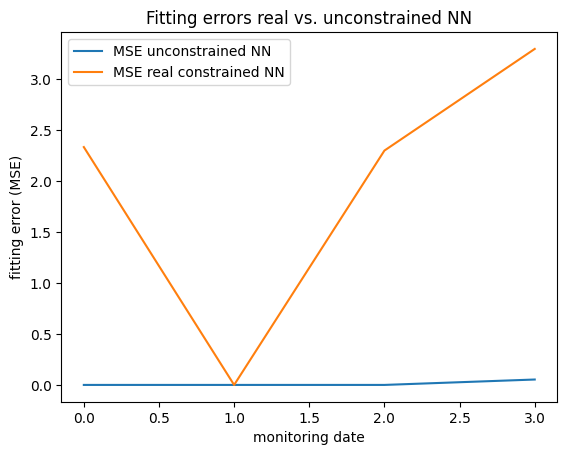

In [124]:
plt.plot(errors_uncon, label= 'MSE unconstrained NN')
plt.plot(errors_real, label= 'MSE real constrained NN')
# plt.plot(errors, 'k--', label='default RLNN')
plt.title('Fitting errors real vs. unconstrained NN')
plt.xlabel('monitoring date')
plt.ylabel('fitting error (MSE)')
plt.legend()
plt.show()

In [125]:
import numpy as np
import matplotlib.pyplot as plt

def plot_error_distributions(
    errors_array,
    net_label="Unconstrained Net",
    confidence_type="percentile"
):
    """
    Plots a histogram of errors for each date in errors_array,
    calculates mean and 95% confidence intervals, and displays them.

    Args:
        errors_array : np.ndarray of shape (sample_size, no_mon+1)
                       errors_array[m,i] = error for path m at date i
        net_label    : str, name to display in the plot title
        confidence_type : 'percentile' or 'normal'
                          - 'percentile': uses np.percentile([2.5, 97.5])
                          - 'normal':    mean +/- 1.96 * std / sqrt(N)
    """

    n_dates = errors_array.shape[1]  # no_mon+1
    sample_size = errors_array.shape[0]

    for i in range(n_dates):
        errors_i = errors_array[:, i]  # shape (sample_size,)

        # 1) Mean
        mean_err = np.mean(errors_i)

        # 2) 95% CI
        if confidence_type == "percentile":
            lower_ci = np.percentile(errors_i, 2.5)
            upper_ci = np.percentile(errors_i, 97.5)
        else:
            # normal approximation
            std_err = np.std(errors_i, ddof=1)
            se = std_err / np.sqrt(sample_size)
            lower_ci = mean_err - 1.96 * se
            upper_ci = mean_err + 1.96 * se

        # 3) Plot histogram
        plt.figure(figsize=(7, 4))
        plt.hist(errors_i, bins=40, alpha=0.7, edgecolor='black')
        plt.grid(True)

        # Title & labels
        plt.title(f"{net_label}\nDate i={i} errors\n"
                  f"mean={mean_err:.4f}, 95% CI=({lower_ci:.4f}, {upper_ci:.4f})")
        plt.xlabel("Error value")
        plt.ylabel("Frequency")

        plt.show()


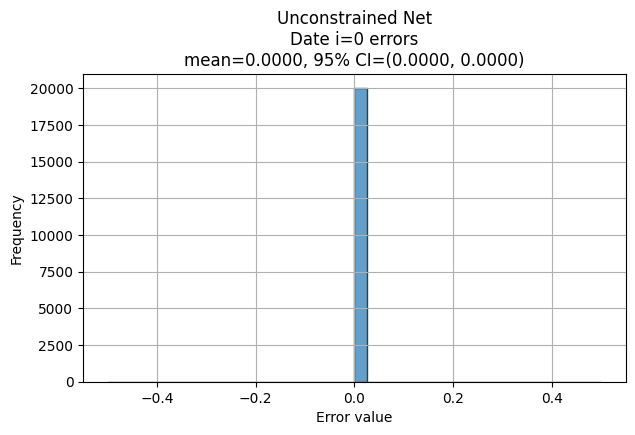

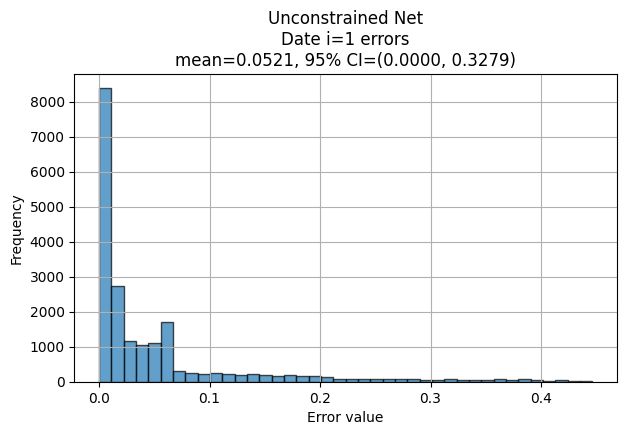

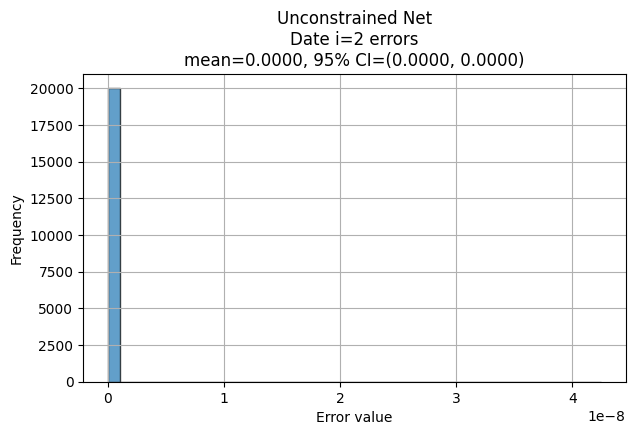

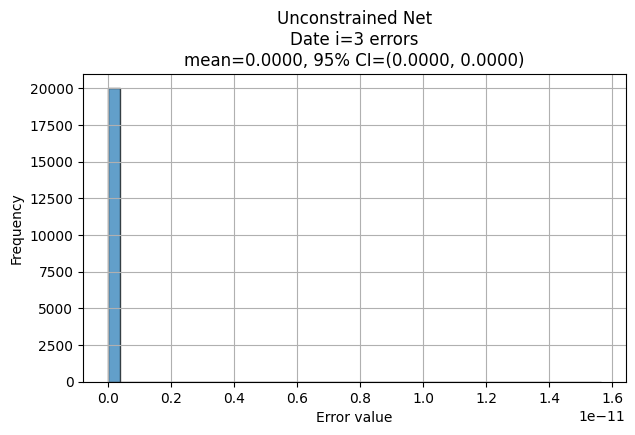

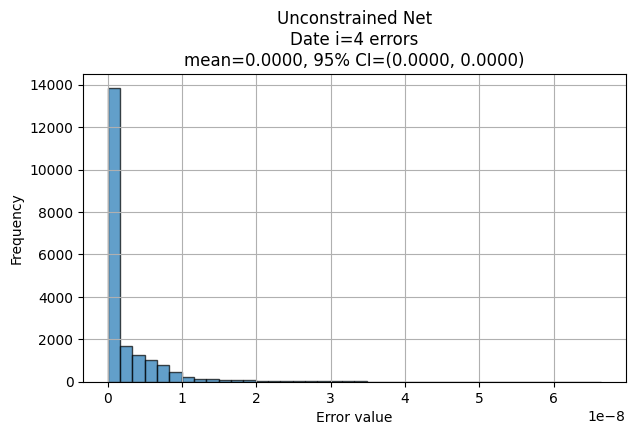

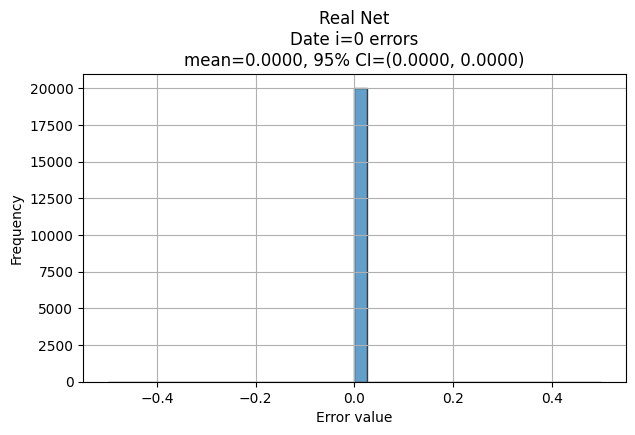

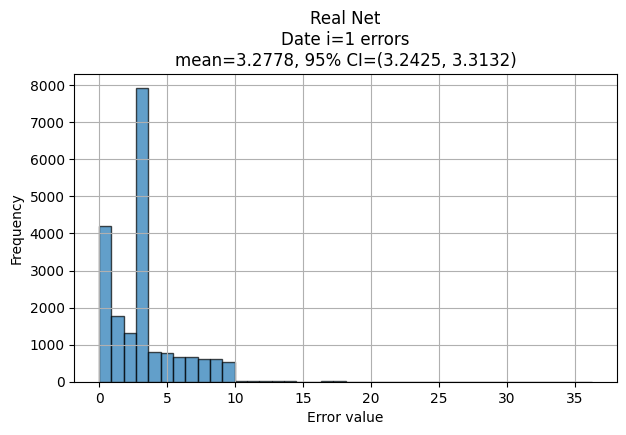

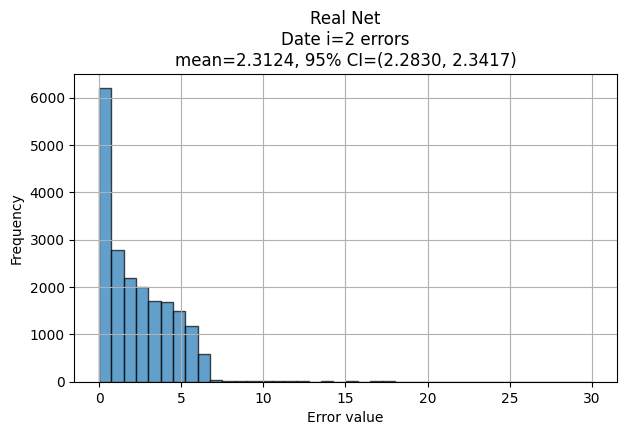

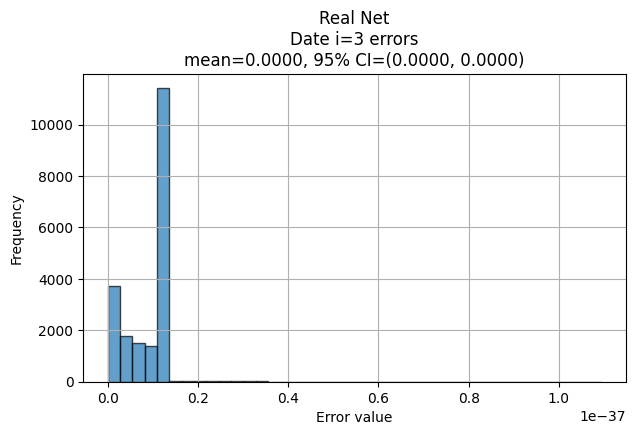

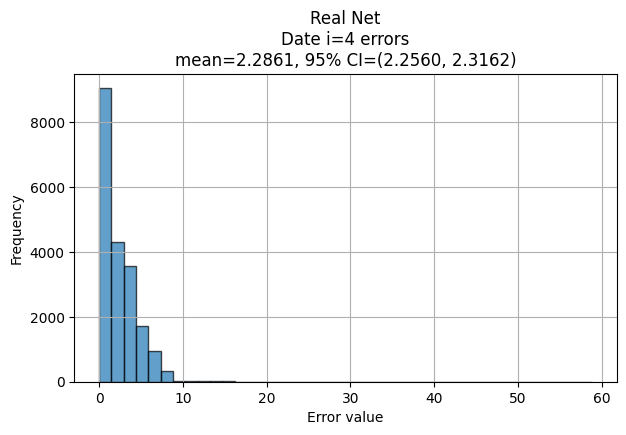

In [126]:
# Plot histograms, mean, 95% CI for unconstrained net errors
plot_error_distributions(
    errors_array = unconstrained_fit_errors,
    net_label    = "Unconstrained Net",
    confidence_type="percentile"
)

# Plot for real net
plot_error_distributions(
    errors_array = real_fit_errors,
    net_label    = "Real Net",
    confidence_type="normal"
)


In [127]:

real_fit_errors[:,1:].reshape(1,-1).squeeze()

array([5.12910940e-01, 6.16889433e-01, 1.14294176e-38, ...,
       4.41864899e+00, 6.98665071e-39, 6.60806130e-01], shape=(80000,))

In [131]:
nPaths_hedge = 10000

hedge_paths = stock_price_simulator(S0, r, vol, T, no_mon, nPaths_hedge)


In [132]:
# final_price_uncon, final_price_real, all_weights_uncon, all_weights_real, errors_uncon, errors_real, real_portfolios = RLNN_Algo_with_RealRefit(
#     S0=100,
#     K=105,
#     r=0.05,
#     vol=0.20,
#     sample_size=20000,
#     no_mon=4,
#     T=1,
#     style='put',
#     no_hidden_units=8,
#     l_rate2=0.01,
#     calls_df=calls_df,
#     puts_df=puts_df,
#     mismatch_tol=1e-3
# )


In [130]:
def hedge_simulation_with_real_portfolios_bsvalue(
    stock_paths,         # shape (nPaths, N+1)
    real_portfolios,     # list of portfolios from map_nn_weights_to_portfolio(...)
    final_price_real,    # real-net Bermudan price at t=0
    r, sigma, T, K, style='put'
):
    """
    Hedging simulation for a Bermudan option using the 'real net' portfolios
    from RLNN_Algo_with_RealRefit.

    Arguments:
    ----------
    stock_paths     : (nPaths, N+1) array of simulated prices (time steps = 0..N).
    real_portfolios : list of length (N+1) or (N), 
                      each an output of map_nn_weights_to_portfolio(...).
                      Typically real_portfolios[0] is for t=N, real_portfolios[1] for t=N-1, ...
    final_price_real: float, the real net's computed option price at t=0
    r, sigma, T     : usual parameters
    K, style        : strike and 'call' or 'put'
    
    Returns:
    --------
    hedge_errors : array of shape (nPaths,).
                   The difference: (final cash - actual payoff) on each path.
    """

    nPaths, steps = stock_paths.shape
    # steps should be N+1 (for N intervals).
    # The RLNN code often appends real_portfolios in backward order:
    #   real_portfolios[0] -> time N
    #   real_portfolios[1] -> time N-1
    # ...
    # so let's reverse them so that real_portfolios[0] -> time 0, etc.
    real_portfolios = real_portfolios[::-1]

    dt = T / (steps - 1)
    hedge_errors = np.zeros(nPaths, dtype=float)

    for p_idx in range(nPaths):
        # (A) Initialize cash: we "sell" the option at price final_price_real
        cash_account = final_price_real

        # (B) At t=0, we buy the portfolio for time-0 (if it exists)
        # real_portfolios[0] should correspond to time=0
        current_portfolio = real_portfolios[0]
        # The cost to buy it is:
        cost_0 = price_portfolio_bs(
            S_array=np.array([stock_paths[p_idx, 0]]), 
            portfolio=current_portfolio,
            r=r, sigma=sigma,
            tau=dt  # or maybe the time from t=0 to final maturity T
        )[0]
        cash_account -= cost_0

        # (C) Move forward in time, rebalancing at each i=1..N
        exercised_early = False
        for i in range(1, steps): 
            # 1) Let cash grow at the risk-free rate
            cash_account *= np.exp(r * dt)

            # 2) Check immediate payoff
            S_now = stock_paths[p_idx, i]
            immediate_payoff = payoff_fun(S_now, K, style)

            # 3) Compute the "continuation" value of the next portfolio
            #    i.e. real_portfolios[i], if i < steps
            #    But if i >= len(real_portfolios), we are out of portfolios
            if i < len(real_portfolios):
                next_portfolio = real_portfolios[i]
                next_port_val = price_portfolio_bs(
                    S_array=np.array([S_now]),
                    portfolio=next_portfolio,
                    r=r, sigma=sigma,
                    tau=(steps - 1 - i) * dt  # time left to maturity
                )[0]
            else:
                # No portfolio data => e.g. i=N
                next_portfolio = None
                next_port_val = 0.0

            # 4) Compare: if immediate exercise is better, exercise now
            if immediate_payoff > next_port_val:
                # We close out the *current* portfolio
                curr_port_val = price_portfolio_bs(
                    S_array=np.array([S_now]),
                    portfolio=current_portfolio,
                    r=r, sigma=sigma,
                    tau=(steps - 1 - i) * dt
                )[0]
                cash_account += curr_port_val
                # The hedge error is final cash - payoff
                hedge_errors[p_idx] = cash_account - immediate_payoff
                exercised_early = True
                break
            else:
                # 5) Otherwise, we close out the old portfolio
                curr_port_val = price_portfolio_bs(
                    S_array=np.array([S_now]),
                    portfolio=current_portfolio,
                    r=r, sigma=sigma,
                    tau=(steps - 1 - i) * dt
                )[0]
                cash_account += curr_port_val

                # 6) Buy the new portfolio for time i
                if next_portfolio is not None:
                    cost_new = price_portfolio_bs(
                        S_array=np.array([S_now]),
                        portfolio=next_portfolio,
                        r=r, sigma=sigma,
                        tau=(steps - 1 - i) * dt
                    )[0]
                    cash_account -= cost_new
                    current_portfolio = next_portfolio
                else:
                    current_portfolio = []

        # (D) If we never exercised, we are at final maturity i=N
        if not exercised_early:
            S_final = stock_paths[p_idx, -1]
            payoff_final = payoff_fun(S_final, K, style)
            # close out final portfolio
            curr_port_val = price_portfolio_bs(
                S_array=np.array([S_final]),
                portfolio=current_portfolio,
                r=r, sigma=sigma,
                tau=0.0
            )[0]
            # also one last growth in the cash account
            cash_account *= np.exp(r * dt)
            cash_account += curr_port_val
            hedge_errors[p_idx] = cash_account - payoff_final

    return hedge_errors


In [133]:
hedge_err_real = hedge_simulation_with_real_portfolios_bsvalue(
    stock_paths = hedge_paths,
    real_portfolios = real_portfolios,  # The list of dicts from map_nn_weights_to_portfolio
    final_price_real = final_price_real,
    r = r,
    sigma = vol,
    T = T,
    K = K,
    style = 'put'
)


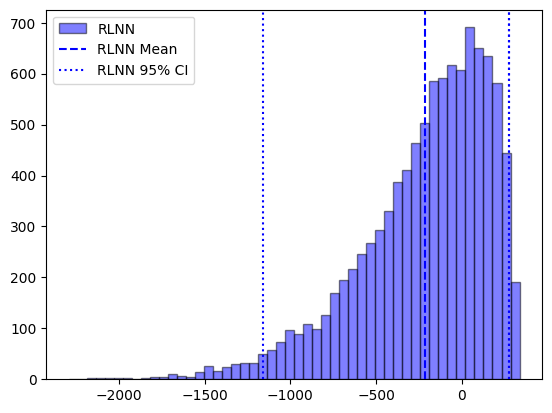

In [134]:
def compute_95ci(data):
    lower = np.percentile(data, 2.5)
    upper = np.percentile(data, 97.5)
    return lower, upper
ci_rlnn_12 = compute_95ci(hedge_err_real)
ci_bin_12 = compute_95ci(hedge_err_real)
mean_rlnn_12 = hedge_err_real.mean()
mean_bin_12 = hedge_err_real.mean()


plt.hist(hedge_err_real, bins=50, alpha=0.5, color='blue', edgecolor='black', label='RLNN')
plt.axvline(x=mean_rlnn_12, color='blue', linestyle='--', label='RLNN Mean')
plt.axvline(ci_rlnn_12[0], color='blue', linestyle=':', label='RLNN 95% CI')
plt.axvline(ci_rlnn_12[1], color='blue', linestyle=':')
plt.axvline(ci_bin_12[1], color='blue', linestyle=':')
plt.legend()
plt.show()

In [135]:
def hedge_simulation_with_real_portfolios_marketvalue(
    stock_paths,         # shape (nPaths, N+1)
    real_portfolios,     # list of length N+1 (in backward order)
    final_price_real,    # real-net Bermudan price at t=0
    r, T, K, style='put',
    use_quote='mid'
):
    """
    A pathwise hedging simulation for a Bermudan 'put' or 'call' using the 'real net' 
    portfolios from RLNN_Algo_with_RealRefit. We value each portfolio with real-market 
    quotes (bid/ask/last) rather than a model.

    Returns:
      hedge_errors: np.array (nPaths,) 
                    hedge error per path = final cash - final payoff.
    """
    nPaths, steps = stock_paths.shape
    # steps = N+1 if there are N intervals

    # The RLNN code typically stores portfolios in reverse order: 
    #   real_portfolios[0] => t=N, 
    #   real_portfolios[1] => t=N-1, ...
    # so let's reverse them to align with forward time indexing.
    real_portfolios = real_portfolios[::-1]  # now real_portfolios[0] => time 0
    
    dt = T / (steps - 1)
    hedge_errors = np.zeros(nPaths, dtype=float)

    for p_idx in range(nPaths):
        # (A) Start with cash = final_price_real (we "sold" the option)
        cash_account = final_price_real

        # (B) Buy the time-0 portfolio
        current_portfolio = real_portfolios[0]
        cost_0 = price_portfolio_market(current_portfolio, use_quote=use_quote)
        cash_account -= cost_0  # pay cost_0

        exercised_early = False

        # (C) Move forward in time from i=1..N
        for i in range(1, steps):
            # 1) The cash grows at risk-free rate for dt
            cash_account *= np.exp(r * dt)

            # 2) Check immediate payoff
            S_now = stock_paths[p_idx, i]
            immediate_exercise = payoff_fun(S_now, K, style)

            # 3) If we have a portfolio for time i, let's see how it would be priced
            if i < len(real_portfolios):
                next_portfolio = real_portfolios[i]
                # we can interpret "time left" as (N - i)*dt
                time_left = (steps - 1 - i)*dt
                next_port_val = price_portfolio_market(next_portfolio, use_quote=use_quote)
            else:
                next_portfolio = None
                next_port_val = 0.0

            # 4) If immediate exercise is bigger than next portfolio value => exercise
            if immediate_exercise > next_port_val:
                # close out the current portfolio
                curr_port_val = price_portfolio_market(current_portfolio, use_quote=use_quote)
                cash_account += curr_port_val
                # hedge error = final cash - payoff
                hedge_errors[p_idx] = cash_account - immediate_exercise
                exercised_early = True
                break
            else:
                # otherwise we continue => close old portfolio, buy new one
                curr_port_val = price_portfolio_market(current_portfolio, use_quote=use_quote)
                cash_account += curr_port_val  # we "sell" old portfolio

                if next_portfolio is not None:
                    cost_new = price_portfolio_market(next_portfolio, use_quote=use_quote)
                    cash_account -= cost_new
                    current_portfolio = next_portfolio
                else:
                    current_portfolio = []

        # (D) If we never exercised, we are at final time i=N
        if not exercised_early:
            S_final = stock_paths[p_idx, -1]
            payoff_final = payoff_fun(S_final, K, style)
            # close out final portfolio
            curr_port_val = price_portfolio_market(current_portfolio, use_quote=use_quote)
            # let cash grow one last dt
            cash_account *= np.exp(r * dt)
            cash_account += curr_port_val

            # hedge error = final cash - final payoff
            hedge_errors[p_idx] = cash_account - payoff_final

    return hedge_errors


In [136]:
hedge_err_real = hedge_simulation_with_real_portfolios_marketvalue(
    stock_paths = hedge_paths,
    real_portfolios = real_portfolios,  # The list of dicts from map_nn_weights_to_portfolio
    final_price_real = final_price_real,
    r = r,
    # sigma = vol,
    T = T,
    K = K,
    style = 'put'
)


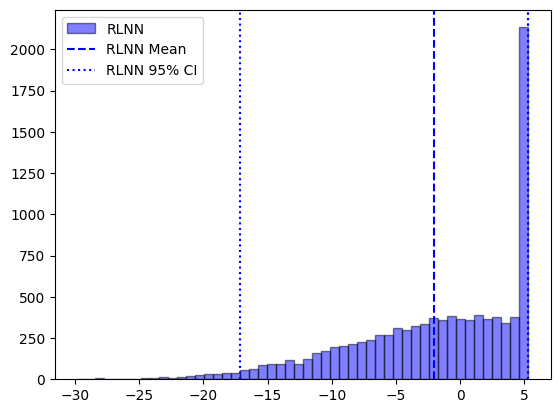

In [137]:
def compute_95ci(data):
    lower = np.percentile(data, 2.5)
    upper = np.percentile(data, 97.5)
    return lower, upper
ci_rlnn_12 = compute_95ci(hedge_err_real)
ci_bin_12 = compute_95ci(hedge_err_real)
mean_rlnn_12 = hedge_err_real.mean()
mean_bin_12 = hedge_err_real.mean()


plt.hist(hedge_err_real, bins=50, alpha=0.5, color='blue', edgecolor='black', label='RLNN')
plt.axvline(x=mean_rlnn_12, color='blue', linestyle='--', label='RLNN Mean')
plt.axvline(ci_rlnn_12[0], color='blue', linestyle=':', label='RLNN 95% CI')
plt.axvline(ci_rlnn_12[1], color='blue', linestyle=':')
plt.axvline(ci_bin_12[1], color='blue', linestyle=':')
plt.legend()
plt.show()

(array([7.4863e+04, 4.9580e+03, 1.2700e+02, 3.5000e+01, 1.2000e+01,
        3.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([7.67891983e-47, 5.88903240e+00, 1.17780648e+01, 1.76670972e+01,
        2.35561296e+01, 2.94451620e+01, 3.53341944e+01, 4.12232268e+01,
        4.71122592e+01, 5.30012916e+01, 5.88903240e+01]),
 <BarContainer object of 10 artists>)

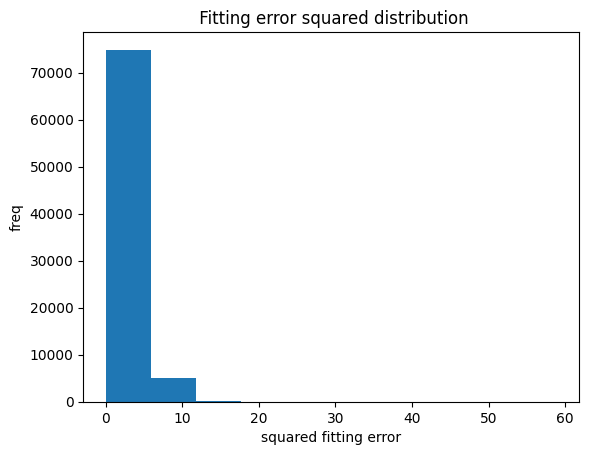

In [128]:
plt.title(' Fitting error squared distribution')
plt.xlabel('squared fitting error')
plt.ylabel('freq')
plt.hist(real_fit_errors[:,1:].reshape(1,-1).squeeze())

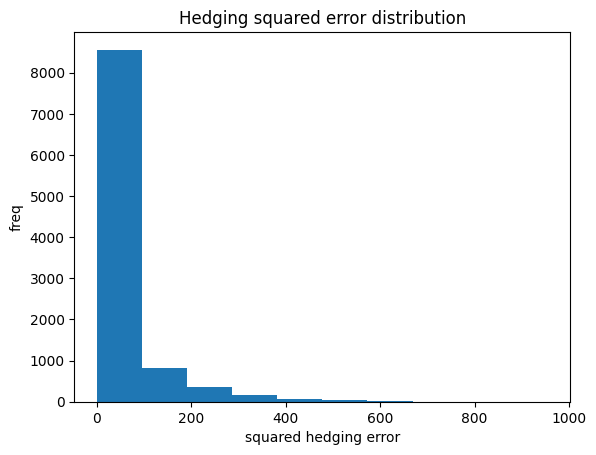

In [129]:
plt.title('Hedging squared error distribution')
plt.xlabel('squared hedging error')
plt.hist(hedge_err_real**2)
plt.ylabel('freq')
plt.show()